# 1. Importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.express as px

from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import warnings
from numpy import mean
from numpy import std


# 2. Reading the data


In [2]:
df_train = pd.read_csv('C:\\Users\\jerri\\Desktop\\Problem statement\\Loan Default Prediction\\data\\Train_Dataset.csv',low_memory=False)
df_test = pd.read_csv('C:\\Users\\jerri\\Desktop\\Problem statement\\Loan Default Prediction\\data\\Test_Dataset.csv',low_memory=False)

In [3]:
#Shape of dataframe
print(" Shape of training dataframe: ", df_train.shape)
print(" Shape of testing dataframe: ", df_test.shape)

# Drop duplicates
df_train.drop_duplicates()
df_test.drop_duplicates()
print(df_train.shape)
print(df_test.shape)

 Shape of training dataframe:  (121856, 40)
 Shape of testing dataframe:  (80900, 39)
(121856, 40)
(80900, 39)


In [4]:
null= df_train.isnull().sum().sort_values(ascending=False)
total =df_train.shape[0]
percent_missing= (df_train.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, 
                        keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", 
       missing_data.sort_values(by ='Total missing', ascending = False))

Null Values in each column:
                    column name  Total missing  Percent missing
0                Own_House_Age          80095         0.657292
1               Score_Source_1          68835         0.564888
2        Social_Circle_Default          61928         0.508206
3            Client_Occupation          41435         0.340032
4               Score_Source_3          26921         0.220925
5                Credit_Bureau          18540         0.152147
6                      ID_Days           5968         0.048976
7               Score_Source_2           5686         0.046662
8   Population_Region_Relative           4857         0.039859
9                 Loan_Annuity           4812         0.039489
10          Client_Income_Type           3701         0.030372
11         Client_Housing_Type           3687         0.030257
12                Phone_Change           3664         0.030068
13    Application_Process_Hour           3663         0.030060
14                   House

In [5]:
class_df = df_train.groupby('Default').count()['ID'].reset_index().sort_values(by='ID',ascending=False)
class_df.style.background_gradient(cmap='winter')

,Default,ID
0,0,112011
1,1,9845


In [6]:
train_null_unique= df_train.Own_House_Age.unique()
test_null_unique= df_test.Own_House_Age.unique()
print(train_null_unique)
print (test_null_unique)

[nan  0.  6. 10. 14.  1.  3.  2.  7. 15. 31. 16. 13. 64.  8. 20. 17.  4.
 18. 22.  9.  5. 23. 12. 32. 27. 50. 19. 29. 24. 65. 11. 25. 26. 30. 28.
 39. 21. 44. 35. 33. 37. 40. 36. 34. 41. 57. 45. 38. 43. 63. 42. 54. 49.
 69. 46.]
[nan  6.  7.  4.  3. 15. 17. 14. 12. 10.  1.  5. 18.  0.  2. 11.  9.  8.
 23. 16. 25. 13. 37. 21. 24. 65. 64. 28. 22. 20. 19. 27. 26. 34. 32. 29.
 31. 30. 39. 46. 40. 36. 33. 41. 35. 45. 42. 38. 43. 44. 49. 63. 54. 55.
 51.]


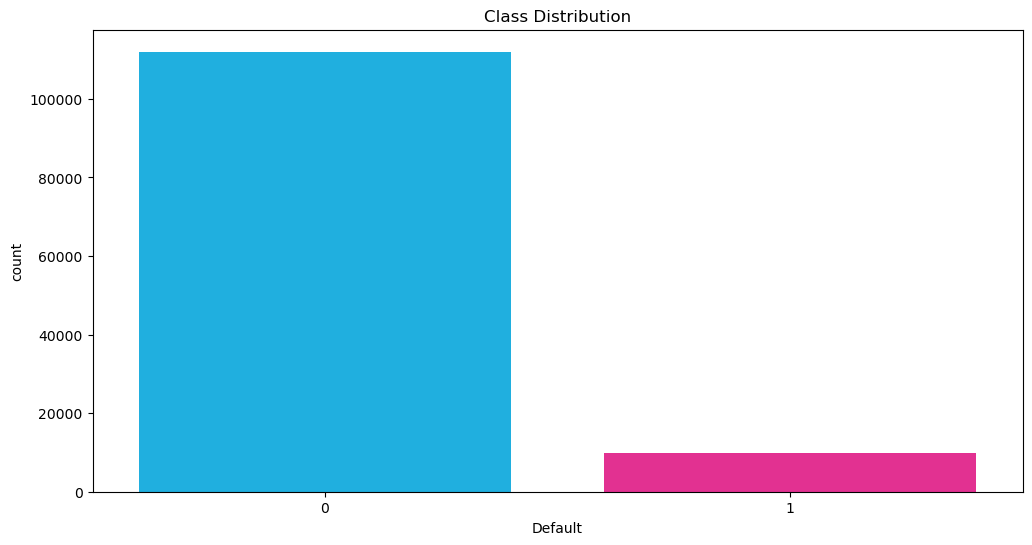

% of no defaults       : 91.92079175420169
Number of no defaults     : 112011
% of defaults         : 8.07920824579832
Number of defaults    : 9845


In [7]:
#Graph
my_pal = {0: 'deepskyblue', 1: 'deeppink'}

plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'Default', data = df_train, palette = my_pal)
plt.title('Class Distribution')
plt.show()

# Count and %
Count_Normal_transacation = len(df_train[df_train['Default']==0])
Count_Fraud_transacation = len(df_train[df_train['Default']==1]) 
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of no defaults       :', Percentage_of_Normal_transacation*100)
print('Number of no defaults     :', Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of defaults         :',Percentage_of_Fraud_transacation*100)
print('Number of defaults    :', Count_Fraud_transacation)

# Highly skewed distribution with 8% defaults and 92% no defaults, so a naive model which predicts no default for all records will have 92% accuracy

In [8]:
# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(df_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()
    
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = df_train.loc[df_train['Default'] != 0]
    t0 = df_train.loc[df_train['Default'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="Default = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="Default = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();


In [9]:
def plot_bar_comp(var,nrow=2):
    
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.countplot(df_train[feature])
        sns.countplot(df_train[feature])
        plt.ylabel('Count plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [10]:
# Box Plot for one feature
def plot_box(feature, color):
    plt.figure(figsize=(10,6))
    plt.title("Box Plot of %s" % feature)
    sns.boxplot(y=df_train[feature].dropna(),x= df_train.Default,color=color)
    plt.show()

In [11]:
# Bar Plot for one feature
def plot_bar(feature):
    plt.figure(figsize=(10,50))
    sns.catplot(y=feature, hue="Default", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_train);

count    41761.000000
mean        12.157324
std         12.056079
min          0.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         69.000000
Name: Own_House_Age, dtype: float64


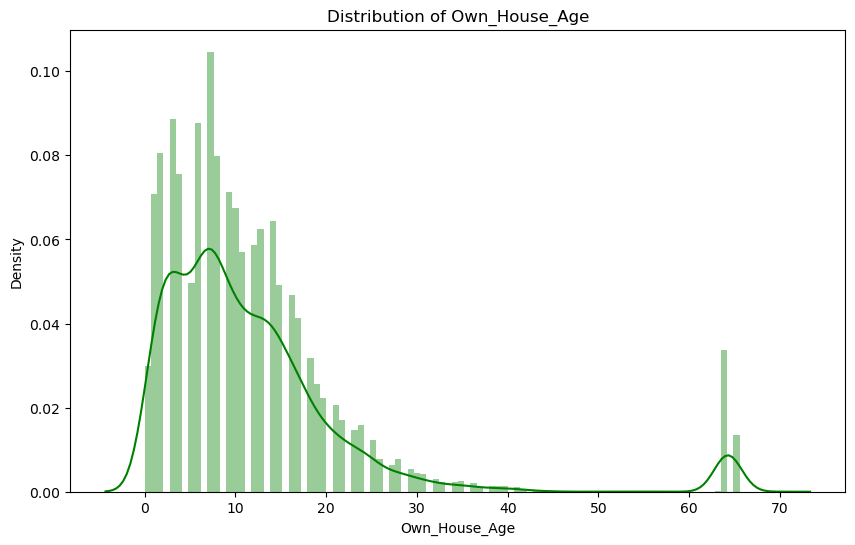

In [12]:
print(df_train.Own_House_Age.describe())
plot_distribution('Own_House_Age','green')

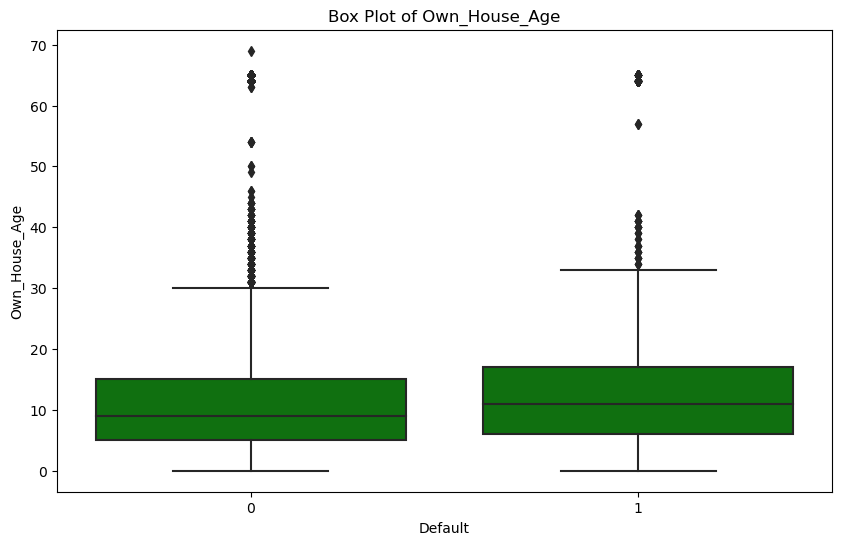

In [13]:
plot_box("Own_House_Age", "green")

In [14]:
#Number of observations in column
obs = len(df_train.Own_House_Age)
print("No. of observations in column: ",obs)

# calculate summary statistics
data_mean, data_std = mean(df_train.Own_House_Age), std(df_train.Own_House_Age)
print('Statistics: Mean=%.3f, Std dev=%.3f' % (data_mean, data_std))
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in df_train.Own_House_Age if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

No. of observations in column:  121856
Statistics: Mean=12.157, Std dev=12.056
Identified outliers: 1379


In [15]:
def impute_outlier(x):
    if x <= lower:
        return(data_mean)
    elif x>= (upper):
        return(data_mean)
    else:
        return(x)
df_train["Own_House_Age_new"]= df_train["Own_House_Age"].apply(impute_outlier)
print("No. of observations in column: ",len(df_train.Own_House_Age_new))

No. of observations in column:  121856


In [16]:
def impute_missing(x):
    if x == np.nan:
        return(median(x))
    else:
        return(x)

df_train["Own_House_Age_new"]= df_train["Own_House_Age"].apply(impute_missing)
print("No. of observations in column: ",len(df_train.Own_House_Age_new))

No. of observations in column:  121856


In [17]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
df_train['Own_House_Age_bins'] = pd.qcut(df_train['Own_House_Age'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
df_train['Own_House_Age_bins'].value_counts()

Own_House_Age_bins
Low        11384
High       10351
Extreme    10131
Medium      9895
Name: count, dtype: int64

<Figure size 1000x5000 with 0 Axes>

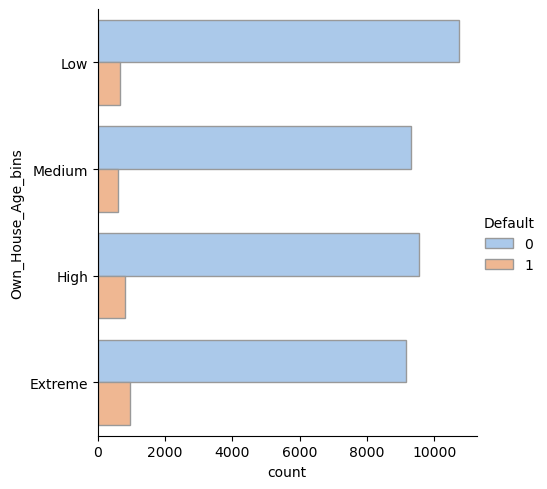

In [18]:
plot_bar("Own_House_Age_bins")

# There is a tendency to default more of the age of the house is more based on above chart

count                53021.0
mean      0.5012129250527902
std      0.21120444861128987
min              0.014568132
25%              0.333480523
50%              0.504656688
75%              0.673890059
max              0.945741288
Name: Score_Source_1, dtype: object


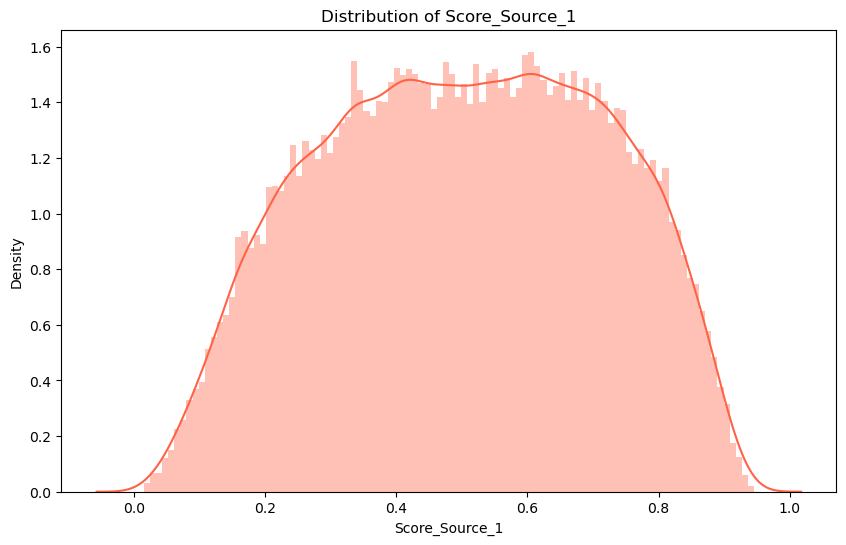

In [19]:
print(df_train.Score_Source_1.describe().astype(str))
plot_distribution('Score_Source_1','tomato')

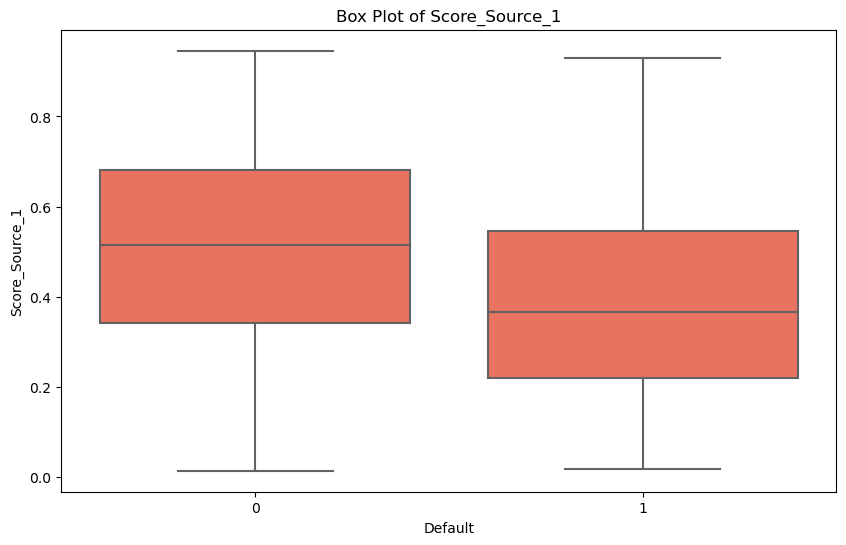

In [20]:
plot_box("Score_Source_1", "tomato")

# There are no outliers, so we just need to replace the missing values with median as the distribution is nearly normal

In [21]:
df_train["Score_Source_1_new"]= df_train["Score_Source_1"].apply(impute_missing)
print("No. of observations in column: ",len(df_train.Score_Source_1_new))

No. of observations in column:  121856


In [22]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
df_train['Score_Source_1_bins'] = pd.qcut(df_train['Score_Source_1'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
df_train['Score_Source_1_bins'].value_counts()

Score_Source_1_bins
Low        13257
High       13257
Medium     13254
Extreme    13253
Name: count, dtype: int64

<Figure size 1000x5000 with 0 Axes>

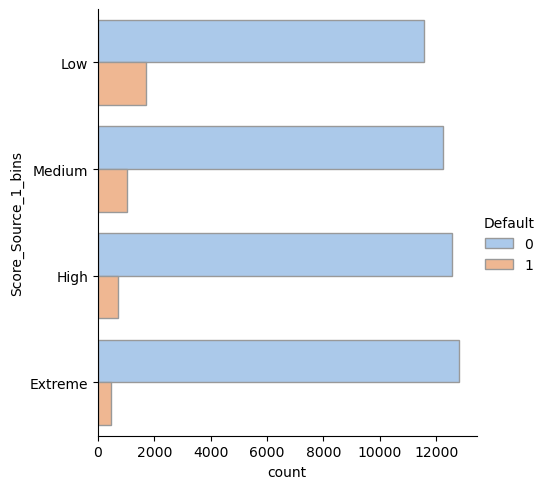

In [23]:
plot_bar("Score_Source_1_bins")

# There is a tendency to default more at lower scores than higher scores

count                59928.0
mean     0.11742785509277799
std      0.10797382393875432
min                      0.0
25%                   0.0577
50%                   0.0887
75%                   0.1485
max                      1.0
Name: Social_Circle_Default, dtype: object


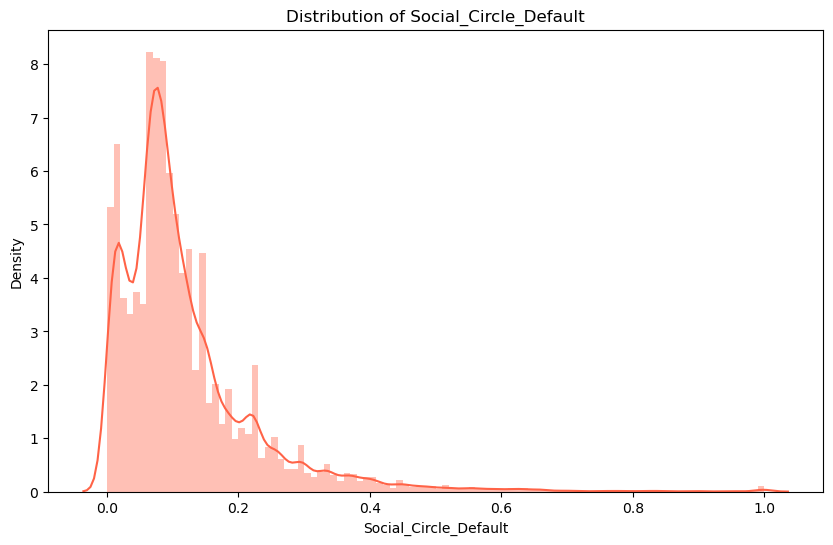

In [24]:
print(df_train.Social_Circle_Default.describe().astype(str))
plot_distribution('Social_Circle_Default','tomato')

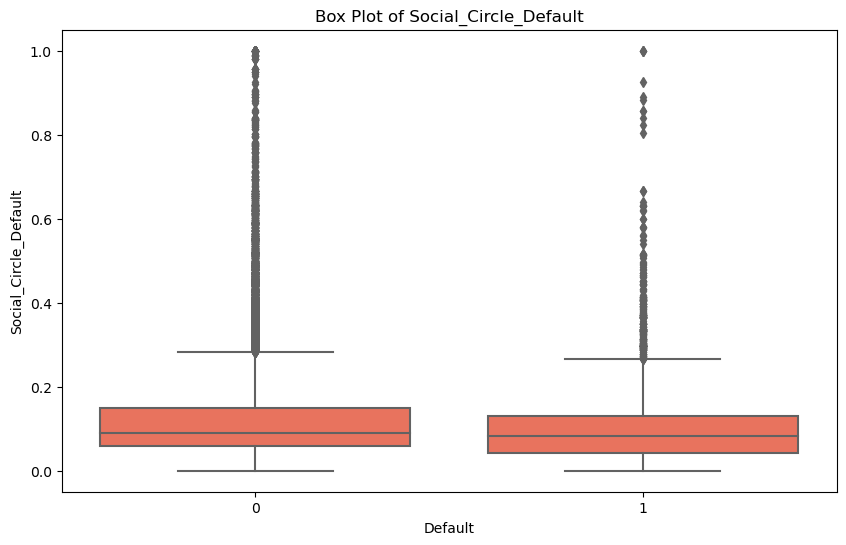

In [25]:
plot_box("Social_Circle_Default", "tomato")

In [26]:
df_train["Social_Circle_Default_new"]= df_train["Social_Circle_Default"].apply(impute_missing)
print("No. of observations in column: ",len(df_train.Social_Circle_Default_new))

No. of observations in column:  121856


In [27]:
bin_labels = ['Low', 'Medium', 'High', 'Extreme']
df_train['Social_Circle_Default'] = pd.qcut(df_train['Social_Circle_Default'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels)
df_train['Social_Circle_Default'].value_counts()

Social_Circle_Default
High       15826
Low        15112
Medium     14963
Extreme    14027
Name: count, dtype: int64

<Figure size 1000x5000 with 0 Axes>

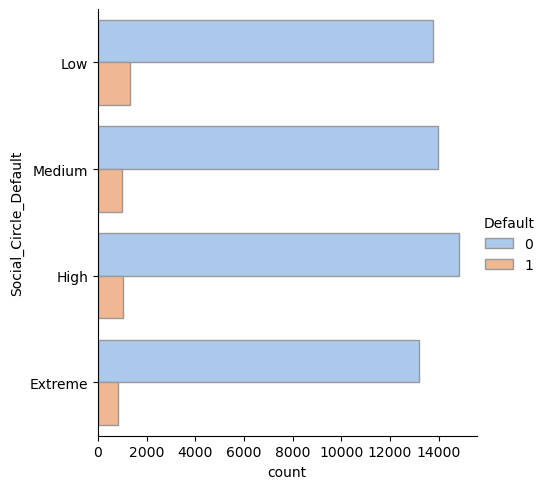

In [28]:
plot_bar("Social_Circle_Default");

# Lower social circle score has more probability of default

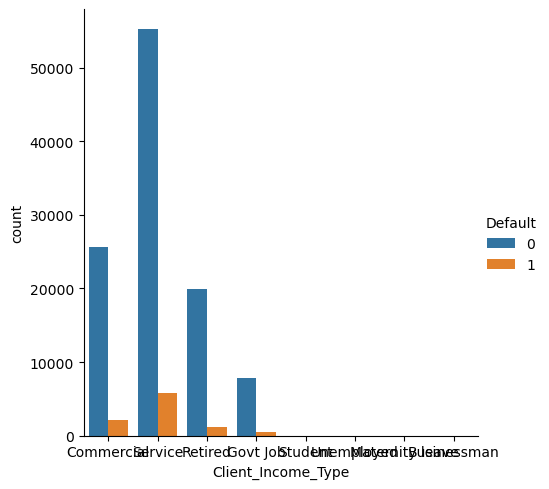

In [29]:
sns.catplot(data=df_train,kind='count',x='Client_Income_Type',hue='Default')

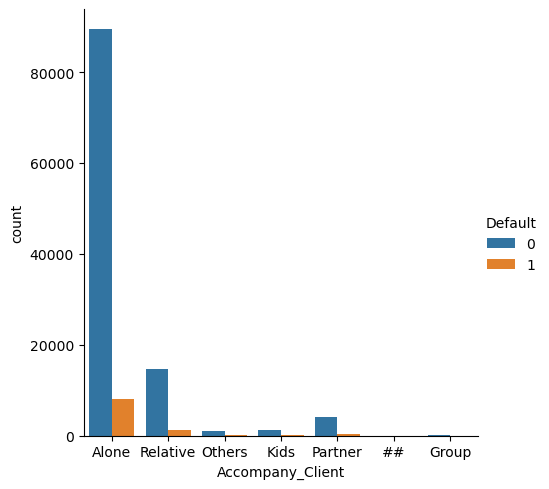

In [30]:
sns.catplot(data=df_train,kind='count',x='Accompany_Client',hue='Default')

# People who came alonetend to default more

In [31]:
df_train

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default,Own_House_Age_new,Own_House_Age_bins,Score_Source_1_new,Score_Source_1_bins,Social_Circle_Default_new
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957,1062,6123,383,NaN,1,1,0,Sales,2.0,2.0,6.0,17.0,Yes,Yes,Self-employed,0.568066,0.478787,NaN,Low,63.0,NaN,0,NaN,NaN,0.568066,High,0.0186
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162,4129,7833,21,0.0,1,0,1,NaN,2.0,2.0,3.0,10.0,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0,0.0,Low,0.563360,High,NaN
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,Service,Graduation dropout,W,Male,CL,Family,0.0228,16790,5102,NaN,331,NaN,1,0,0,Realty agents,2.0,2.0,4.0,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655054,Medium,277.0,0.0,0,NaN,NaN,NaN,NaN,0.0742
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195,365243,NaN,775,NaN,1,0,0,NaN,2.0,3.0,2.0,15.0,Yes,Yes,XNA,NaN,0.135182,0.631354537,NaN,1700.0,3.0,0,NaN,NaN,NaN,NaN,NaN
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366,2977,5516,4043,6.0,1,0,0,Laborers,4.0,1.0,3.0,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355638717,Extreme,674.0,1.0,0,6.0,Medium,0.508199,High,0.2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121851,12207714,29250,0.0,0.0,NaN,1.0,0.0,107820,3165.3,Relative,Service,Secondary,M,Female,CL,Home,0.031329,12889,2863,2661,2943,NaN,1,0,0,Laborers,2.0,2.0,4.0,16.0,Yes,No,Business Entity Type 2,NaN,0.173527,0.184116156,Low,0.0,1.0,1,NaN,NaN,NaN,NaN,0.0577
121852,12173765,15750,0.0,1.0,1.0,0.0,0.0,104256,3388.05,Alone,Commercial,Graduation,M,Female,CL,Home,0.018209,8648,636,902,1209,NaN,1,1,0,Sales,2.0,3.0,4.0,12.0,Yes,Yes,Self-employed,NaN,0.371559,0.406617437,Medium,4.0,0.0,0,NaN,NaN,NaN,NaN,0.0825
121853,12103937,8100,0.0,1.0,0.0,1.0,1.0,55107.9,2989.35,Alone,Govt Job,Secondary,M,Male,CL,Home,0.008068,9152,1623,3980,353,NaN,1,0,0,High skill tech,3.0,3.0,5.0,11.0,No,No,Trade: type 6,0.169049,0.048079,NaN,NaN,0.0,NaN,0,NaN,NaN,0.169049,Low,NaN
121854,12170623,38250,1.0,1.0,0.0,1.0,0.0,45000,2719.35,Alone,Service,Graduation,M,Female,CL,Home,0.028663,10290,847,895,2902,4.0,1,0,0,Sales,2.0,2.0,1.0,12.0,Yes,Yes,Business Entity Type 3,0.182737,0.103538,0.077498546,High,0.0,2.0,0,4.0,Low,0.182737,Low,0.0979


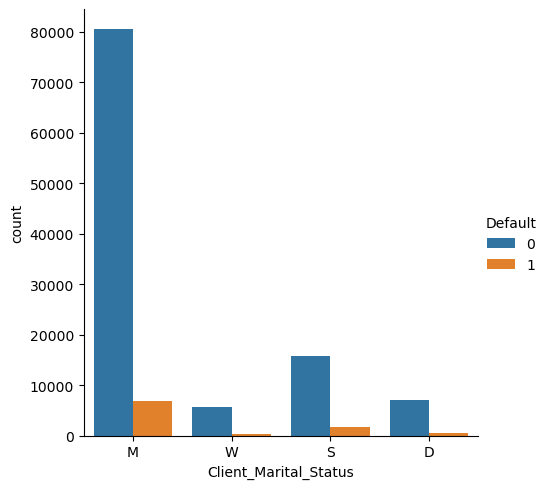

In [32]:
sns.catplot(data=df_train,kind='count',x='Client_Marital_Status',hue='Default')

# Married people tend to default more, followed by single and divorced

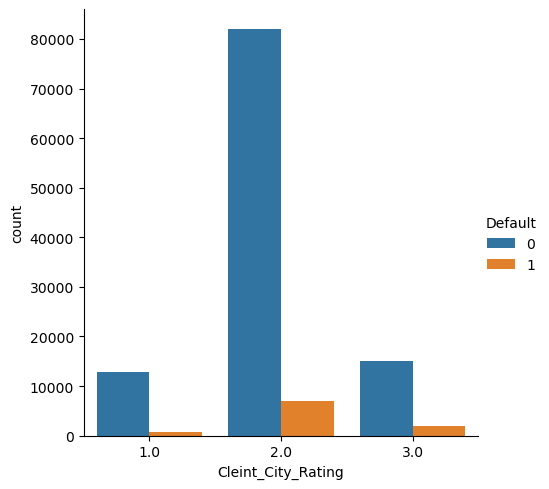

In [33]:
sns.catplot(data=df_train,kind='count',x='Cleint_City_Rating',hue='Default')

# Preparing Datasets

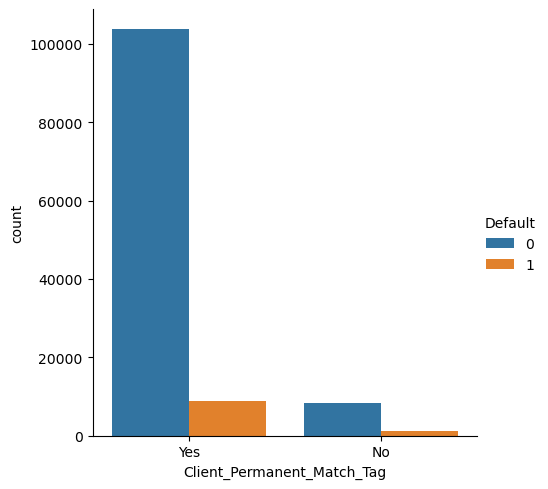

In [34]:
sns.catplot(data=df_train,kind='count',x='Client_Permanent_Match_Tag',hue='Default')

In [35]:
# For Train dataset
drop_cols=['ID','Application_Process_Day','Application_Process_Hour']
df_train.drop(columns=drop_cols,axis=1,inplace=True)
df_train['Score_Source_3']=df_train['Score_Source_3'].str.replace('&','').replace('',np.nan)
df_train['Score_Source_3']=df_train['Score_Source_3'].str.replace('#','').replace('',np.nan)
df_train['Score_Source_3']=df_train['Score_Source_3'].astype(float)
df_train['Client_Income']=df_train['Client_Income'].str.replace('$','').replace('',np.nan)
df_train['Client_Income']=df_train['Client_Income'].astype(float)
df_train['Credit_Amount']=df_train['Credit_Amount'].str.replace('$','').replace('',np.nan)
df_train['Credit_Amount']=df_train['Credit_Amount'].astype(float)
df_train['Loan_Annuity']=df_train['Loan_Annuity'].str.replace('#VALUE!','').replace('',np.nan)
df_train['Loan_Annuity']=df_train['Loan_Annuity'].str.replace('$','').replace('',np.nan)
df_train['Loan_Annuity']=df_train['Loan_Annuity'].astype(float)

In [36]:
# For Test dataset
drop_cols=['ID','Application_Process_Day','Application_Process_Hour']
df_test.drop(columns=drop_cols,axis=1,inplace=True)
df_test['Score_Source_3']=df_test['Score_Source_3'].str.replace('&','').replace('',np.nan)
df_test['Score_Source_3']=df_test['Score_Source_3'].str.replace('#','').replace('',np.nan)
df_test['Score_Source_3']=df_test['Score_Source_3'].astype(float)
df_test['Client_Income']=df_test['Client_Income'].str.replace('$','').replace('',np.nan)
df_test['Client_Income']=df_test['Client_Income'].astype(float)
df_test['Credit_Amount']=df_test['Credit_Amount'].str.replace('$','').replace('',np.nan)
df_test['Credit_Amount']=df_test['Credit_Amount'].astype(float)
df_test['Loan_Annuity']=df_test['Loan_Annuity'].str.replace('#VALUE!','').replace('',np.nan)
df_test['Loan_Annuity']=df_test['Loan_Annuity'].str.replace('$','').replace('',np.nan)
df_test['Loan_Annuity']=df_test['Loan_Annuity'].astype(float)

# Imputation
  1. Imputing numerical data with mean 

In [37]:
for col in df_train:
    if df_train[col].dtype in [int,float]:
        mean_val = df_train[col].mean()
        df_train[col].fillna(mean_val,inplace=True)

# Imputing test data below
for col in df_test:
    if df_test[col].dtype in [int,float]:
        mean_val = df_test[col].mean()
        df_test[col].fillna(mean_val,inplace=True)

In [38]:
(df_train.isnull().sum())*100/len(df_train)

Client_Income                  0.000000
Car_Owned                      0.000000
Bike_Owned                     0.000000
Active_Loan                    0.000000
House_Own                      0.000000
Child_Count                    0.000000
Credit_Amount                  0.000000
Loan_Annuity                   0.000000
Accompany_Client               1.432839
Client_Income_Type             3.037191
Client_Education               2.991236
Client_Marital_Status          2.850085
Client_Gender                  1.980206
Loan_Contract_Type             2.996159
Client_Housing_Type            3.025702
Population_Region_Relative     3.985852
Age_Days                       2.954307
Employed_Days                  2.994518
Registration_Days              2.965796
ID_Days                        4.897584
Own_House_Age                  0.000000
Mobile_Tag                     0.000000
Homephone_Tag                  0.000000
Workphone_Working              0.000000
Client_Occupation             34.003250


In [39]:
(df_test.isnull().sum())*100/len(df_test)

Client_Income                  0.000000
Car_Owned                      0.000000
Bike_Owned                     0.000000
Active_Loan                    0.000000
House_Own                      0.000000
Child_Count                    0.000000
Credit_Amount                  0.000000
Loan_Annuity                   0.000000
Accompany_Client               1.493201
Client_Income_Type             3.091471
Client_Education               2.904821
Client_Marital_Status          3.019778
Client_Gender                  2.011125
Loan_Contract_Type             2.868974
Client_Housing_Type            2.976514
Population_Region_Relative     4.042027
Age_Days                       3.064277
Employed_Days                  2.992583
Registration_Days              2.964153
ID_Days                        4.797281
Own_House_Age                  0.000000
Mobile_Tag                     0.000000
Homephone_Tag                  0.000000
Workphone_Working              0.000000
Client_Occupation             34.419036


In [40]:
# dropping columns whose missing percentage is greater than 30 and columns created for EDA
train_cols = ['Client_Occupation','Social_Circle_Default_new','Score_Source_1_bins','Score_Source_1_new','Own_House_Age_bins',
              'Own_House_Age_new','Social_Circle_Default']
test_cols = ['Client_Occupation','Social_Circle_Default']
df_train.drop(train_cols,axis=1,inplace=True)
df_test.drop(test_cols,axis = 1, inplace=True)

In [41]:
(df_train.isnull().sum())*100/len(df_train)

Client_Income                 0.000000
Car_Owned                     0.000000
Bike_Owned                    0.000000
Active_Loan                   0.000000
House_Own                     0.000000
Child_Count                   0.000000
Credit_Amount                 0.000000
Loan_Annuity                  0.000000
Accompany_Client              1.432839
Client_Income_Type            3.037191
Client_Education              2.991236
Client_Marital_Status         2.850085
Client_Gender                 1.980206
Loan_Contract_Type            2.996159
Client_Housing_Type           3.025702
Population_Region_Relative    3.985852
Age_Days                      2.954307
Employed_Days                 2.994518
Registration_Days             2.965796
ID_Days                       4.897584
Own_House_Age                 0.000000
Mobile_Tag                    0.000000
Homephone_Tag                 0.000000
Workphone_Working             0.000000
Client_Family_Members         0.000000
Cleint_City_Rating       

In [42]:
(df_test.isnull().sum())*100/len(df_test)

Client_Income                 0.000000
Car_Owned                     0.000000
Bike_Owned                    0.000000
Active_Loan                   0.000000
House_Own                     0.000000
Child_Count                   0.000000
Credit_Amount                 0.000000
Loan_Annuity                  0.000000
Accompany_Client              1.493201
Client_Income_Type            3.091471
Client_Education              2.904821
Client_Marital_Status         3.019778
Client_Gender                 2.011125
Loan_Contract_Type            2.868974
Client_Housing_Type           2.976514
Population_Region_Relative    4.042027
Age_Days                      3.064277
Employed_Days                 2.992583
Registration_Days             2.964153
ID_Days                       4.797281
Own_House_Age                 0.000000
Mobile_Tag                    0.000000
Homephone_Tag                 0.000000
Workphone_Working             0.000000
Client_Family_Members         0.000000
Cleint_City_Rating       

In [43]:
# # From the above analysis , i see a small data percentage is missing 
# 1. We can drop the missing data or
# 2. We can fill in the missing data.
# I am dropping the data in this case
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [44]:
df_train.count()

Client_Income                 81945
Car_Owned                     81945
Bike_Owned                    81945
Active_Loan                   81945
House_Own                     81945
Child_Count                   81945
Credit_Amount                 81945
Loan_Annuity                  81945
Accompany_Client              81945
Client_Income_Type            81945
Client_Education              81945
Client_Marital_Status         81945
Client_Gender                 81945
Loan_Contract_Type            81945
Client_Housing_Type           81945
Population_Region_Relative    81945
Age_Days                      81945
Employed_Days                 81945
Registration_Days             81945
ID_Days                       81945
Own_House_Age                 81945
Mobile_Tag                    81945
Homephone_Tag                 81945
Workphone_Working             81945
Client_Family_Members         81945
Cleint_City_Rating            81945
Client_Permanent_Match_Tag    81945
Client_Contact_Work_Tag     

In [45]:
print(df_test.count())

Client_Income                 51824
Car_Owned                     51824
Bike_Owned                    51824
Active_Loan                   51824
House_Own                     51824
Child_Count                   51824
Credit_Amount                 51824
Loan_Annuity                  51824
Accompany_Client              51824
Client_Income_Type            51824
Client_Education              51824
Client_Marital_Status         51824
Client_Gender                 51824
Loan_Contract_Type            51824
Client_Housing_Type           51824
Population_Region_Relative    51824
Age_Days                      51824
Employed_Days                 51824
Registration_Days             51824
ID_Days                       51824
Own_House_Age                 51824
Mobile_Tag                    51824
Homephone_Tag                 51824
Workphone_Working             51824
Client_Family_Members         51824
Cleint_City_Rating            51824
Client_Permanent_Match_Tag    51824
Client_Contact_Work_Tag     

# Categorical Data needs to be encoded 

In [46]:
from sklearn.preprocessing import OrdinalEncoder
enc=OrdinalEncoder()
# Iterating throught the DataFrame, checking for object or category dtype features. 
# If yes then encode else continue
for col in df_train:
    if df_train[col].dtype in [object,'category']:
        df_train[col]=enc.fit_transform(df_train[col].astype(str).values.reshape(-1,1))
    else:
        continue
for col in df_test:
    if df_test[col].dtype in [object,'category']:
        df_test[col]=enc.fit_transform(df_test[col].astype(str).values.reshape(-1,1))
    else:
        continue

In [47]:
df_train.count()

Client_Income                 81945
Car_Owned                     81945
Bike_Owned                    81945
Active_Loan                   81945
House_Own                     81945
Child_Count                   81945
Credit_Amount                 81945
Loan_Annuity                  81945
Accompany_Client              81945
Client_Income_Type            81945
Client_Education              81945
Client_Marital_Status         81945
Client_Gender                 81945
Loan_Contract_Type            81945
Client_Housing_Type           81945
Population_Region_Relative    81945
Age_Days                      81945
Employed_Days                 81945
Registration_Days             81945
ID_Days                       81945
Own_House_Age                 81945
Mobile_Tag                    81945
Homephone_Tag                 81945
Workphone_Working             81945
Client_Family_Members         81945
Cleint_City_Rating            81945
Client_Permanent_Match_Tag    81945
Client_Contact_Work_Tag     

In [48]:
df_test.count()

Client_Income                 51824
Car_Owned                     51824
Bike_Owned                    51824
Active_Loan                   51824
House_Own                     51824
Child_Count                   51824
Credit_Amount                 51824
Loan_Annuity                  51824
Accompany_Client              51824
Client_Income_Type            51824
Client_Education              51824
Client_Marital_Status         51824
Client_Gender                 51824
Loan_Contract_Type            51824
Client_Housing_Type           51824
Population_Region_Relative    51824
Age_Days                      51824
Employed_Days                 51824
Registration_Days             51824
ID_Days                       51824
Own_House_Age                 51824
Mobile_Tag                    51824
Homephone_Tag                 51824
Workphone_Working             51824
Client_Family_Members         51824
Cleint_City_Rating            51824
Client_Permanent_Match_Tag    51824
Client_Contact_Work_Tag     

<Axes: xlabel='Default', ylabel='count'>

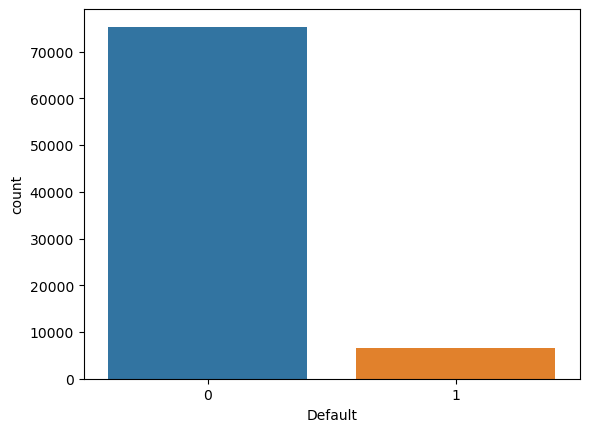

In [49]:
sns.countplot(df_train, x="Default")

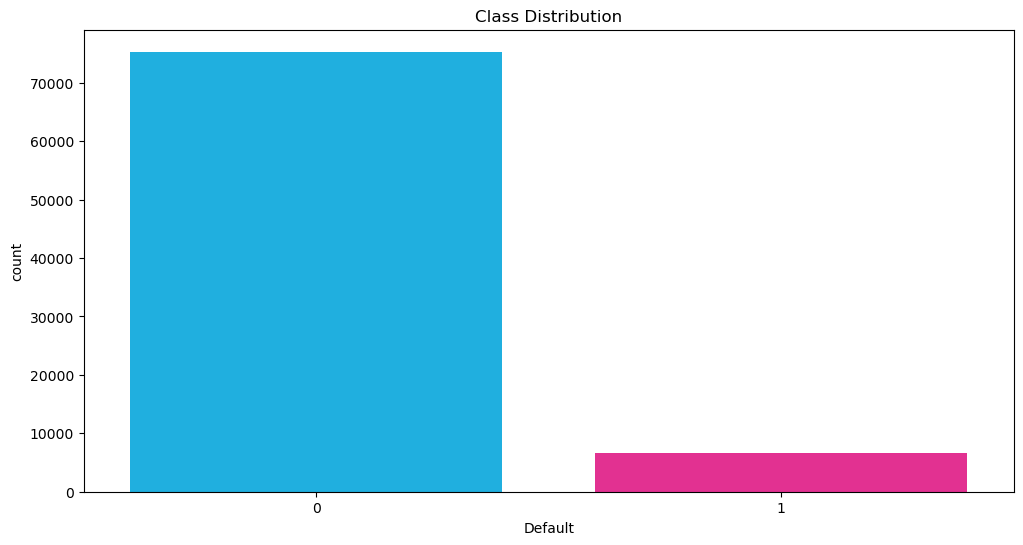

% of no defaults       : 91.91530904875222
Number of no defaults     : 75320
% of defaults         : 8.084690951247788
Number of defaults    : 6625


In [50]:
#Graph
my_pal = {0: 'deepskyblue', 1: 'deeppink'}

plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'Default', data = df_train, palette = my_pal)
plt.title('Class Distribution')
plt.show()

# Count and %
Count_Normal_transacation = len(df_train[df_train['Default']==0])
Count_Fraud_transacation = len(df_train[df_train['Default']==1]) 
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of no defaults       :', Percentage_of_Normal_transacation*100)
print('Number of no defaults     :', Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of defaults         :',Percentage_of_Fraud_transacation*100)
print('Number of defaults    :', Count_Fraud_transacation)

In [51]:
x=df_train.drop('Default',axis=1)
y=df_train['Default']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 101)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [52]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)


print(confusion_matrix(y_test, logpred))
print(round(accuracy_score(y_test, logpred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[15044     0]
 [ 1345     0]]
92.0


In [53]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, logpred))
print("F1 Score ",f1_score(y_test, logpred))
print("Recall Score ",recall_score(y_test, logpred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, logpred))

Accuracy of model  0.9179327597778998
F1 Score  0.0
Recall Score  0.0
Balanced Accuracy Score  0.5


In [54]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, rfc_pred))
print(round(accuracy_score(y_test, rfc_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())


[[15011    33]
 [ 1227   118]]
92.0


In [55]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, rfc_pred))
print("F1 Score ",f1_score(y_test, rfc_pred))
print("Recall Score ",recall_score(y_test, rfc_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_pred))

Accuracy of model  0.9231191652937946
F1 Score  0.15775401069518716
Recall Score  0.08773234200743495
Balanced Accuracy Score  0.5427693882331777


In [56]:
from sklearn.naive_bayes import GaussianNB

# train model
nb = GaussianNB().fit(X_train, y_train)

# predict on test set
nb_pred = nb.predict(X_test)
print(confusion_matrix(y_test, nb_pred))
print(round(accuracy_score(y_test, nb_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[14876   168]
 [ 1328    17]]
91.0


In [57]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, nb_pred))
print("F1 Score ",f1_score(y_test, nb_pred))
print("Recall Score ",recall_score(y_test, nb_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, nb_pred))

Accuracy of model  0.9087192629202514
F1 Score  0.022222222222222223
Recall Score  0.012639405204460967
Balanced Accuracy Score  0.5007360812249372


In [58]:
from sklearn.linear_model import SGDClassifier

# train model
sgd = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_train, y_train)

# predict on test set
sgd_pred = sgd.predict(X_test)
print(confusion_matrix(y_test, sgd_pred))
print(round(accuracy_score(y_test, sgd_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[15044     0]
 [ 1345     0]]
92.0


In [59]:
from sklearn.tree import DecisionTreeClassifier

# train model
dtree = DecisionTreeClassifier(max_depth = 10, random_state= 101, max_features =None , min_samples_leaf = 30).fit(X_train, y_train)

# predict on test set
dtree_pred = dtree.predict(X_test)
print(confusion_matrix(y_test, dtree_pred))
print(round(accuracy_score(y_test, dtree_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[14992    52]
 [ 1311    34]]
92.0


In [60]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, dtree_pred))
print("F1 Score ",f1_score(y_test, dtree_pred))
print("Recall Score ",recall_score(y_test, dtree_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, dtree_pred))

Accuracy of model  0.9168344621392397
F1 Score  0.047519217330538085
Recall Score  0.025278810408921933
Balanced Accuracy Score  0.5109111414448225


In [61]:
# XG Boost

from xgboost import XGBClassifier

# train model
xgb = XGBClassifier().fit(X_train, y_train)

# predict on test set
xgb_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, xgb_pred))
print(round(accuracy_score(y_test, xgb_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[14975    69]
 [ 1273    72]]
92.0


In [62]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, xgb_pred))
print("F1 Score ",f1_score(y_test, xgb_pred))
print("Recall Score ",recall_score(y_test, xgb_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, xgb_pred))

Accuracy of model  0.9181158093843431
F1 Score  0.09690444145356662
Recall Score  0.053531598513011154
Balanced Accuracy Score  0.5244725261908316


# treating imbalanced dataset

In [63]:
from imblearn.over_sampling import SMOTE


# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [64]:
from sklearn.linear_model import SGDClassifier

# train model
sgd = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_train, y_train)

# predict on test set
sgd_pred = sgd.predict(X_test)
print(confusion_matrix(y_test, sgd_pred))
print(round(accuracy_score(y_test, sgd_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[13369  5452]
 [ 1147   519]]
68.0


In [65]:
from sklearn.tree import DecisionTreeClassifier

# train model
dtree = DecisionTreeClassifier(max_depth = 10, random_state= 101, max_features =None , min_samples_leaf = 30).fit(X_train, y_train)

# predict on test set
dtree_pred = dtree.predict(X_test)
print(confusion_matrix(y_test, dtree_pred))
print(round(accuracy_score(y_test, dtree_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[17982   839]
 [ 1492   174]]
89.0


In [66]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, dtree_pred))
print("F1 Score ",f1_score(y_test, dtree_pred))
print("Recall Score ",recall_score(y_test, dtree_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, dtree_pred))

Accuracy of model  0.8862205300922537
F1 Score  0.12989921612541994
Recall Score  0.10444177671068428
Balanced Accuracy Score  0.5299319557800273


In [67]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, rfc_pred))
print(round(accuracy_score(y_test, rfc_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, rfc_pred))
print("F1 Score ",f1_score(y_test, rfc_pred))
print("Recall Score ",recall_score(y_test, rfc_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_pred))

[[18714   107]
 [ 1509   157]]
92.0
Accuracy of model  0.9211207106945868
F1 Score  0.16269430051813472
Recall Score  0.09423769507803122
Balanced Accuracy Score  0.544276278068743


In [68]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=300)
etc.fit(X_train, y_train)
etc_pred=etc.predict(X_test)
print(confusion_matrix(y_test, etc_pred))
print(round(accuracy_score(y_test, etc_pred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, etc_pred))
print("F1 Score ",f1_score(y_test, etc_pred))
print("Recall Score ",recall_score(y_test, etc_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, etc_pred))

[[18791    30]
 [ 1459   207]]
93.0
Accuracy of model  0.9273197637526236
F1 Score  0.21755123489227537
Recall Score  0.12424969987995198
Balanced Accuracy Score  0.561327867845507


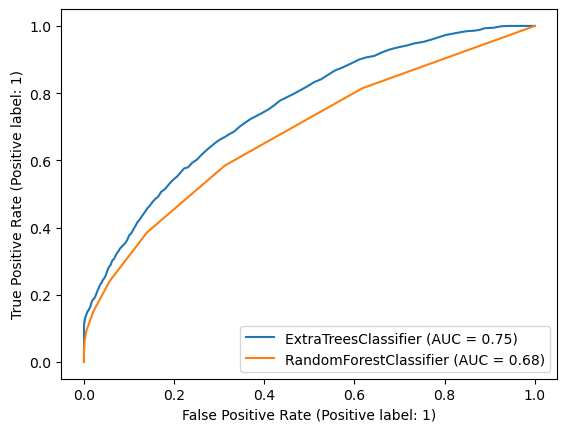

In [72]:
from sklearn.metrics import RocCurveDisplay
etc_disp = RocCurveDisplay.from_estimator(etc, X_test, y_test)
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=etc_disp.ax_)

In [73]:
import pickle
pickle.dump(etc, open('model.pkl', 'wb'))

In [76]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
result = pickled_model.predict(df_test)

In [78]:
df_test['Default_Predicted'] = result
#df_test1 = df_test.append(result)

In [79]:
df_test

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,Default_Predicted
1,13500.0,1.0,1.0,1.0,1.0,3.0,49752.000000,3252.15,1.0,4.0,3.0,1.0,0.0,0.0,1.0,50.0,3090.0,5452.0,9463.0,3181.0,6.000000,1,1,0,5.0,3.0,0.0,1.0,42.0,0.501752,8031.0,0.511575,181.0,1.897432,0
2,38250.0,0.0,1.0,0.0,1.0,0.0,67500.000000,3375.00,1.0,1.0,0.0,1.0,0.0,1.0,1.0,77.0,5772.0,901.0,12462.0,1440.0,12.013727,1,0,1,2.0,1.0,1.0,1.0,5.0,0.501752,30997.0,0.511575,281.0,1.897432,0
4,13500.0,1.0,1.0,0.0,1.0,0.0,43603.200000,2515.95,1.0,4.0,3.0,1.0,0.0,0.0,1.0,39.0,5641.0,261.0,7840.0,2908.0,7.000000,1,0,0,2.0,2.0,1.0,1.0,42.0,0.731110,20182.0,0.730987,927.0,1.000000,0
6,11250.0,1.0,1.0,0.0,1.0,0.0,53366.850000,2273.85,1.0,2.0,3.0,1.0,0.0,0.0,1.0,76.0,7053.0,2424.0,5391.0,5522.0,4.000000,1,0,0,2.0,2.0,1.0,0.0,41.0,0.559248,13035.0,0.375711,2154.0,4.000000,0
8,18000.0,1.0,0.0,0.0,1.0,0.0,53747.100000,5801.40,1.0,1.0,3.0,1.0,0.0,0.0,1.0,80.0,15487.0,2107.0,6747.0,1634.0,3.000000,1,0,0,2.0,1.0,1.0,1.0,16.0,0.431516,31334.0,0.712155,1776.0,5.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80885,40500.0,0.0,0.0,0.0,1.0,1.0,59934.001053,2857.05,1.0,1.0,0.0,1.0,1.0,0.0,1.0,56.0,5353.0,3425.0,1504.0,3575.0,12.013727,1,0,0,3.0,2.0,1.0,1.0,9.0,0.501752,30829.0,0.720944,507.0,0.000000,0
80886,24750.0,1.0,0.0,1.0,1.0,0.0,54213.300000,3957.75,1.0,2.0,0.0,2.0,1.0,0.0,3.0,27.0,1378.0,2522.0,7042.0,3056.0,14.000000,1,0,0,1.0,3.0,1.0,1.0,41.0,0.265116,6348.0,0.736623,1542.0,1.000000,0
80887,11250.0,0.0,1.0,0.0,1.0,0.0,45000.000000,2188.80,1.0,4.0,3.0,1.0,1.0,0.0,1.0,63.0,1059.0,1131.0,3596.0,4153.0,12.013727,1,0,0,2.0,2.0,1.0,1.0,42.0,0.286620,19871.0,0.234015,378.0,0.000000,0
80892,13500.0,0.0,0.0,1.0,1.0,0.0,80865.000000,2621.70,1.0,4.0,3.0,1.0,1.0,0.0,1.0,31.0,3747.0,1999.0,9533.0,4070.0,12.013727,1,0,0,2.0,2.0,1.0,0.0,33.0,0.501752,15760.0,0.511575,0.0,1.897432,0
